In [3]:
import matplotlib.pyplot as plt
import numpy as np
import analyse_usaf_image
import cv2

In [24]:
file_loc = "/media/Saturday/Temporary/xi/MCAM_Re-imaging/abberation test/singlet/center_focus_20240403_180921_945/"
file_name = "cam7_0" + ".tif"

Searching for targets.............................................done
Searching for targets.............................................done
Exception: attempt to get argmin of an empty sequence
Exception: attempt to get argmin of an empty sequence
Exception: attempt to get argmin of an empty sequence
Problem: spline failed for data of size 4
Exception: (m>k) failed for hidden m: fpcurf0:m=3
Problem: spline failed for data of size 4
Exception: (m>k) failed for hidden m: fpcurf0:m=3
Linear fitting gives the smallest period as 20.458931410634854 pixels
Assuming intercept is zero gives 19.94019734650578 +/- 0.14663462124101087
Assuming smallest block is group 7, element 6,
pixel size is 219.9 +/- 1.6 nm
FOV is 450.3x450.3um +/- 0.74%
diagonal is 636.9 +/- 4.7 um


(<Figure size 640x480 with 1 Axes>,
 {'group': 7,
  'element': 6,
  'pixel_nm': 219.88836419298664,
  'pixel_nm_se': 1.616997386657971,
  'field_of_view': array([450.33136987, 450.33136987]),
  'field_of_view_x': 450.3313698672366,
  'field_of_view_y': 450.3313698672366,
  'pixels': (2048, 2048),
  'pixels_x': 2048,
  'pixels_y': 2048,
  'diagonal': 636.8647308283006,
  'fractional_standard_error': 0.007353719659485034,
  'smallest_period_pixels': 19.94019734650578,
  'smallest_period_se': 0.14663462124101087,
  'polyfit_coefficients': array([20.45893141, -0.8472414 ])})

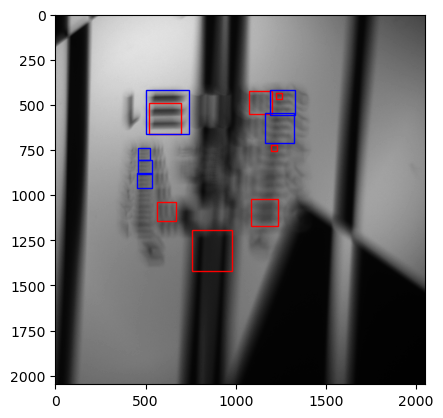

In [26]:
img = cv2.imread(file_loc + file_name)
analyse_usaf_image.analyse_image(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

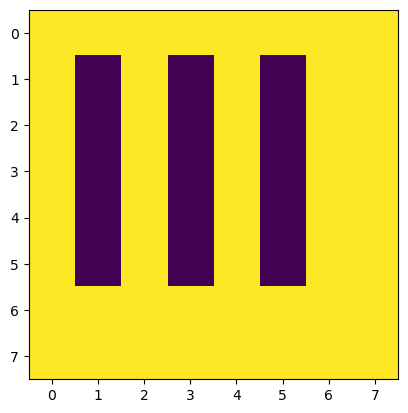

In [19]:
plt.imshow(template(8))

In [8]:
# -*- coding: utf-8 -*-
"""
Analyse a USAF test target image, to determine the image's dimensions.

See: https://en.wikipedia.org/wiki/1951_USAF_resolution_test_chart

(c) Richard Bowman 2017, released under GNU GPL


From Wikipedia, the number of line pairs/mm is 2^(g+(h-1)/6) where g is the
"group number" and h is the "element number".  Each group has 6 elements, 
numbered from 1 to 6.  My ThorLabs test target goes down to group 7, meaning
the finest pitch is 2^(7+(6-1)/6)=2^(47/8)=

"""
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib.patches

from skimage import data
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform
from skimage.draw import ellipse
from skimage.io import imread
import numpy as np
import cv2
from sklearn.cluster import MeanShift
from contextlib import closing

import scipy.ndimage
import scipy.interpolate
import itertools
import os.path
import os
import sys
from skimage.io import imread
from matplotlib.backends.backend_pdf import PdfPages

#################### Rotate the image so the bars are X/Y aligned #############
def find_image_orientation(gray_image, fuzziness = 5):
    """Determine the angle we need to rotate a USAF target image by.
    
    This is a two-step "straightener", first looking at the gradient directions
    in the image, then fine-tuning it to get a more accurate answer.  Rotating
    the image by this amount should cause the bars to align with the x/y axes.
    It may be beneficial to do this iteratively, i.e. run it, then rotate, then
    run it again, then tweak - this should help avoid any issues with linearity
    in the calculation of gradient angles.
    
    fuzziness sets the size of the Gaussian kernel used for gradient estimation
    
    returns: the angle of the bars, as a floating-point number.
    """
    image = gray_image / gray_image.max()
    # Calculate local gradient directions (to find angle)
    Gx = scipy.ndimage.gaussian_filter1d(image, axis=0, order=1, sigma=fuzziness)
    Gy = scipy.ndimage.gaussian_filter1d(image, axis=1, order=1, sigma=fuzziness)
    angles = np.arctan2(Gx, Gy)
    weights = Gx**2+Gy**2
    
    # First, find the histogram and pick the maximum
    h, e = np.histogram(angles % (np.pi), bins=100, weights=weights)
    #plt.plot((e[1:] + e[:-1])/2, h, 'o-')
    rough_angle = ((e[1:] + e[:-1])/2)[np.argmax(h)] #pick the peak
    bin_width = np.mean(np.diff(e))
    
    # Recalculate the histogram about the peak (avoids wrapping issues)
    h, e = np.histogram(((angles - rough_angle + np.pi/4) % (np.pi/2)) - np.pi/4,
                        bins=50, range=(-0.1, 0.1), weights=weights)
    h *= bin_width/np.mean(np.diff(e))
    h /= 2
    #plt.plot((e[1:] + e[:-1])/2+rough_angle, h)
    
    # Use spline interpolation to fit the peak and find the rotation angle
    spline = scipy.interpolate.UnivariateSpline(e[1:-1], np.diff(h))
    root = spline.roots()[np.argmin(spline.roots()**2)] #pick root nearest zero
    #plt.plot(e+rough_angle, spline(e))
    
    fine_angle = root + rough_angle
    
    #TODO: do we want to rotate the image here and repeat the above analysis?
    
    return fine_angle


################### Find the bars ############################

def template(n):
    """Generate a template image of three horizontal bars, n x n pixels
    
    NB the bars occupy the central square of the template, with a margin
    equal to one bar all around.  There are 3 bars and 2 spaces between,
    so bars are m=n/7 wide.
    
    returns: n x n numpy array, uint8
    """
    n = int(n)
    template = np.ones((n, n), dtype=np.uint8)
    template *= 255
    
    for i in range(3):
        template[n//7:-n//7,  (1 + 2*i) * n//7:(2 + 2*i) * n//7] = 0
    return template

def find_elements(image,
                  template_fn=template, 
                  scale_increment=1.04,
                  n_scales=100,
                  return_all=False):
    """Use a multi-scale template match to find groups of 3 bars in the image.
    
    We return a list of tuples, (score, (x,y), size) for each match.
    
    image: a 2D uint8 numpy array in which to search
    template_fn: a function to generate a square uint8 array, which takes one
        argument n that specifies the side length of the square.
    scale_increment: the factor by which the template size is increased each
        iteration.  Should be a floating point number a little bigger than 1.0
    n_scales: the number of sizes searched.  The largest size is half the image
        size.
        
    """
    matches = []
    start = np.log(image.shape[0]/2)/np.log(scale_increment) - n_scales
    print("Searching for targets", end='')
    for nf in np.logspace(start, start + n_scales, base=scale_increment):
        if nf < 28:  #There's no point bothering with tiny boxes...
            continue
        templ = template(nf) #NB n is rounded down from nf
        res = cv2.matchTemplate(image,templ,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        matches.append((max_val, max_loc, templ.shape[0]))
        print('.', end='')
    print("done")
    
    # Take the matches at different scales and filter out the good ones
    scores = np.array([m[0] for m in matches])
    threshold_score = (scores.max() + scores.min()) / 2
    filtered_matches = [m for m in matches if m[0] > threshold_score]
    
    # Group overlapping matches together, and pick the best one
    def overlap1d(x1, n1, x2, n2):
        """Return the overlapping length of two 1d regions
        
        Draw four positions, indicating the edges of the regions (i.e. x1, 
        c1+n1, x2, x2+n2).  The smallest distance between a starting edge (x1
        or x2) and a stopping edge (x+n) gives the overlap.  This will be
        one of the four values in the min().  The overlap can't be <0, so if
        the minimum is negative, return zero.
        """
        return max(min(x1 + n1 - x2, x2 + n2 - x1, n1, n2), 0)
    
    unique_matches = []
    while len(filtered_matches) > 0:
        current_group = []
        new_matches = [filtered_matches.pop()]
        while len(new_matches) > 0:
            current_group += new_matches
            new_matches = []
            for m1 in filtered_matches:
                for m2 in current_group:
                    s1, (x1, y1), n1 = m1
                    s2, (x2, y2), n2 = m2
                    overlap = (overlap1d(x1, n1, x2, n2) * 
                               overlap1d(y1, n1, y2, n2))
                    if overlap > 0.5 * min(n1, n2)**2:
                        new_matches.append(m1)
                        filtered_matches.remove(m1)
                        break
        # Now we should have current_group full of overlapping matches.  Pick
        # the best one.
        best_score_index = np.argmax([m[0] for m in current_group])
        unique_matches.append(current_group[best_score_index])
    
    elements = unique_matches
    if return_all:
        return elements, matches
    else:
        return elements
        

def plot_matches(image, elements, elements_T=[]):
    """Plot the image, then highlight the groups."""
    f, ax = plt.subplots(1,1)
    if len(image.shape)==2:
        ax.imshow(image, cmap='gray')
    elif len(image.shape)==3 and image.shape[2]==3 or image.shape[2]==4:
        ax.imshow(image)
    else:
        raise ValueError("The image must be 2D or 3D")
    for score, (x, y), n in elements:
        ax.add_patch(matplotlib.patches.Rectangle((x,y), n, n, 
                                                  fc='none', ec='red'))
    for score, (y, x), n in elements_T:
        ax.add_patch(matplotlib.patches.Rectangle((x,y), n, n, 
                                                  fc='none', ec='blue'))
    return f
        

def find_peak_position(y, **kwargs):
    """Use spline interpolation to find the peak position of a curve.
    
    We differentiate the curve numerically (no smoothing) then use a spline to
    find the root closest to the middle.  Additional keyword arguments are 
    passed to `scipy.interpolate.UnivariateSpline`.
    
    returns: the floating-point x value (i.e. index) of the peak.
    """
    n = len(y)
    try:
        spline = scipy.interpolate.UnivariateSpline(np.arange(n-1)+0.5, 
                                                    np.diff(y), **kwargs)
    except Exception as e:
        print("Problem: spline failed for data of size {}".format(n))
        raise e
    return spline.roots()[np.argmin((spline.roots()-n/2)**2)] #pick centre root

# Now we've got a list of good elements in the image, with approximate sizes.
# We can extract these for further analysis.
def analyse_elements(image, elements, plot=False):
    """Calculate the precise period of each group of bars, from autocorrelation
    
    returns: a list of tuples, (p1, p2) for each element, where p1 and p2 are
    the distances between the two outer bars and the central bar.
    
    It also correlates each row of the image with the average row, which allows
    us to correct the values for tilt.
    """
    if plot: f, axes = plt.subplots(2,len(elements))
    else: f, axes = None, [[None]*len(elements)]*2
    analysis = []
    for (score, (x, y), n), ax0, ax1 in zip(elements, axes[0], axes[1]):
        try:
            gray_roi = image[y:y+n, x:x+n]
            marginal = np.mean(gray_roi[n*3//14:-n*3//14, :], axis=0) 
                                    # average over the bars, ignoring the ends
            target = marginal[np.newaxis, n//14:-n//14].astype(np.uint8)
                            # target is a 1px-high image with 3 bars in it
            # We correlate the thin target with each row of the image, to
            # recover the tilt of the image.
            slant = cv2.matchTemplate(gray_roi[n*3//14:-n*3//14, :],
                                      target.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
            # threshold and centre of mass for each row
            slant -= slant.min(axis=1)[:,np.newaxis]
            slant /= slant.max(axis=1)[:,np.newaxis]
            slant -= 0.8
            slant[slant < 0] = 0
            shifts = np.sum(slant * np.arange(slant.shape[1]), axis=1)/np.sum(slant, axis=1)
            gradient, offset = np.polyfit(np.arange(len(shifts)), shifts, 1)
            tilt = np.arctan(gradient) # fit the peak in each row to find the angle

            centre = marginal[n*5//14:n*9//14] #the central bar
            ccor = np.convolve(marginal, centre[::-1] - np.mean(centre), mode='valid')
                            # NB the central peak will always be at ccor[n*5//14]
                            # Outer peaks should be that +/- n*2//7
            if plot: ax1.plot(np.abs(np.arange(len(ccor)) - n*5//14), ccor)
            maxcor = ccor[n*5//14]
            period_1 = n*5//14 - find_peak_position(ccor[:n//7])
            period_1 *= np.cos(tilt)
            period_2 = find_peak_position(ccor[4*n//7:]) + 4*n//7 - n*5//14
            period_2 *= np.cos(tilt)
            if plot:
                for x in [period_1, period_2]:
                    ax1.plot(np.abs([x, x]), [0, maxcor])
                ax0.imshow(gray_roi, cmap="cubehelix")
                ax0.axis("off")
                ys = np.arange(len(shifts)) + 3*n//14
                cx = (n-1.)/2
                ax0.plot(shifts - np.mean(shifts) + cx, ys, 'r+') # plot fitted X values
                for x in [-period_1, 0, period_2]:
                    ax0.plot(x + (ys - np.mean(ys)) * np.tan(tilt) + cx, ys - x * np.tan(tilt), 'b-')
                
            analysis.append((period_1, period_2))
        except Exception as e:
            print("Exception: {}".format(e))
    if plot:
        return f, analysis
    else:
        return analysis

def fit_periods(periods, gray_image, g=7, h=6, plot=True):
    """Assume the smallest element is group g, element h, and analyse.
    
    We return a dictionary with relevant parameters of the image.  This
    fits the measured periods of elements in the image to the known
    periods of the USAF pattern, assuming that the smallest period is
    group <g> element <h>.  If plot is set to True, the periods are
    plotted on a graph along with the line of best fit used to calculate
    the magnification.
    """
    minp = np.max(gray_image.shape)
    for p in periods:
        p.sort()
        minp = min(minp, min(p))
        
    xs = []
    for p in periods:
        # The sizes ought to be quantised in the sixth root of 2
        xs.append(2**(np.round(np.log(p/minp)/np.log(2)*6)/6))
   # x = 2**(np.arange(len(p1))/6)
    if plot:
        f, ax = plt.subplots(1,1)
        for x, p in zip(xs, periods):
            ax.plot(x, p, 'o')
    #assume the X and Y magnifications are equal...
    m = np.polyfit(np.concatenate(xs), np.concatenate(periods), 1)
    if plot:
        ax.plot(x, m[0]*x + m[1], '-')
    print("Linear fitting gives the smallest period as {} pixels".format(m[0]))
    rs = np.concatenate(periods)/np.concatenate(xs)
    period_gradient = np.mean(rs)
    period_gradient_se = np.std(rs)/np.sqrt(len(rs) - 1)
    if plot:
        ax.plot(x, period_gradient*x, '-')
    print("Assuming intercept is zero gives {} +/- {}".format(rs.mean(), 
                                              rs.std()/np.sqrt(len(rs)-1)))
    print("Assuming smallest block is group {}, element {},".format(g,h))
    line_pairs_mm = 2**(g + (h - 1)/6.0)
    period_um = 1000 / line_pairs_mm
    pixel_nm = 1000 * period_um / period_gradient
    pixel_nm_se = pixel_nm / period_gradient * period_gradient_se
    print("pixel size is {:.1f} +/- {:.1f} nm".format(pixel_nm, pixel_nm_se))
    FoV = np.array(gray_image.T.shape) * pixel_nm / 1000.0
    print("FOV is {:.1f}x{:.1f}um +/- {:.2f}%".format(FoV[0], FoV[1], pixel_nm_se/pixel_nm*100))
    diagonal = np.sqrt(np.sum(FoV**2))
    print("diagonal is {:.1f} +/- {:.1f} um".format(diagonal, 
                                            diagonal * pixel_nm_se/pixel_nm))
    parameters = {
            'group':g,
            'element':h,
            'pixel_nm':pixel_nm,
            'pixel_nm_se':pixel_nm_se,
            'field_of_view':FoV,
            'field_of_view_x':FoV[0],
            'field_of_view_y':FoV[1],
            'pixels':gray_image.T.shape,
            'pixels_x':gray_image.T.shape[0],
            'pixels_y':gray_image.T.shape[1],
            'diagonal':diagonal,
            'fractional_standard_error':pixel_nm_se/pixel_nm,
            'smallest_period_pixels':period_gradient,
            'smallest_period_se':period_gradient_se,
            'polyfit_coefficients':m,
            }
    if plot:
        return f, parameters
    else:
        return parameters
            
def analyse_image(gray_image, pdf=None):
    """Find USAF groups in the image and fit them to determine magnification.
    
    This is the top-level function that you should call to analyse an image.
    The image should be a 2D numpy array.  If the optional "pdf" argument is
    supplied, several graphs will be plotted into the given PdfPages object.
    
    returns: fig, parameters
    
    fig is a matplotlib figure object plotting to the image with each
    element highlighted in a box.
    parameters is a dictionary summarising the fitted values, as returned
    by fit_periods."""
    elementsx, matchesx = find_elements(gray_image, return_all=True)
    elementsy, matchesy = find_elements(gray_image.T, return_all=True)
    fig = plot_matches(gray_image, elementsx, elementsy)
    fax, analysisx = analyse_elements(gray_image, elementsx, plot=True)
    fay, analysisy = analyse_elements(gray_image.T, elementsy, plot=True)
    
    #Now generate four lists, of first/second periods in X and Y
    periods = [[a[i] for a in analysis] 
                for i in range(2) for analysis in (analysisx, analysisy)]
    
    ffit, parameters = fit_periods(periods, gray_image)
    
    if pdf is not None:
        for f in [fig, fax, fay, ffit]:
            pdf.savefig(f)
    for f in [fax, fay, ffit]:
        plt.close(f)
    return fig, parameters
    
def analyse_file(filename, generate_pdf=True):
    """Analyse the image file specified by the given filename"""
    gray_image = np.mean(imread(filename), axis=2).astype(np.uint8)
    with PdfPages(filename+"_analysis.pdf") as pdf:
        fig, parameters = analyse_image(gray_image, pdf)
        with open(filename+"_analysis.txt",'w') as text:
            text.write("Assuming the smallest element is number {element} from group {group}.\n".format(**parameters))
            text.write("That means one pixel is {pixel_nm} +/- {pixel_nm_se} nm.\n".format(**parameters))
            text.write("The field of view is {field_of_view} um.\n".format(**parameters))
            text.write("\n")
            
            text.write("pixel_nm: {}\n".format(parameters['pixel_nm']))
            text.write("pixel_nm_se: {}\n".format(parameters['pixel_nm_se']))
        fig.suptitle(filename)
        return fig, parameters

def analyse_folders(datasets):
    """Analyse a folder hierarchy containing a number of calibration images.
    
    Given a folder that contains a number of other folders (one per microscope usually),
    find all the USAF images (<datasets>/*/usaf_*.jpg) and analyse them.  It also generates
    a summary file in CSV format, and a PDF with all the images and the detected elements.
    """
    files = []
    for dir in [os.path.join(datasets, d) for d in os.listdir(datasets)]: # if d.startswith('6led')]:
        files += [os.path.join(dir,f) for f in os.listdir(dir) if f.startswith("usaf_") and f.endswith(".jpg")]
    summary_data_columns = ['group', 'element', 'pixel_nm', 'pixel_nm_se', 'diagonal', 
                            'fractional_standard_error', 'smallest_period_pixels', 'smallest_period_se', 'pixels_x', 'pixels_y', 'field_of_view_x', 'field_of_view_y']
    with PdfPages("usaf_calibration.pdf") as pdf, \
        open("usaf_calibration_summary.csv", "w") as summary_text:
        summary_text.write("filename, " + ", ".join(summary_data_columns) + "\n")
        for filename in files:
            print("\nAnalysing file {}".format(filename))
            fig, parameters = analyse_file(filename)
            pdf.savefig(fig)
            summary_text.write(", ".join([filename] + [str(parameters[c]) for c in summary_data_columns]) + "\n")
    
if __name__ == '__main__':
    if len(sys.argv) == 1:
        print("Usage: {} <file_or_folder> [<file2> ...]".format(sys.argv[0]))
        print("If a file is specified, we produce <file>_analysis.pdf and <file>_analysis.txt")
        print("If a folder is specified, we produce usaf_calibration.pdf and usaf_calibration_summary.csv")
        print("as well as the single-file analysis for <folder>/*/usaf_*.jpg")
        print("Multiple files may be specified, using wildcards if your OS supports it - e.g. myfolder/calib*.jpg")
        exit(-1)
    if len(sys.argv) == 2 and os.path.isdir(sys.argv[1]):
        analyse_folders(sys.argv[1])
    else:
        for filename in sys.argv[1:]:
            analyse_file(filename)

FileNotFoundError: No such file: '/home/xi/usaf_analysis/--f=/home/xi/.local/share/jupyter/runtime/kernel-v2-405191EXItfiT9oStc.json'